In [ ]:
# 1. Install required packages (run once)
!pip install -q yfinance statsmodels matplotlib

In [ ]:
# 2. Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
# 3. Download Nike (NKE) data from Yahoo Finance
df = yf.download("NKE", start="2022-01-01", end="2025-07-28", auto_adjust=True)
df = df[['Close']].dropna()
df.index = pd.to_datetime(df.index)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 4. Train/test split
df_train = df.iloc[:-10]
df_test = df.iloc[-10:]

In [ ]:
# 5. Summary statistics
print("Summary Statistics (Training Set):")
print(df_train.describe())

print(f"\nTotal observations: {df.shape[0]}")
print(f"Training set: {df_train.shape[0]}")
print(f"Test set: {df_test.shape[0]}")

Summary Statistics (Training Set):
Price        Close
Ticker         NKE
count   883.000000
mean     96.640341
std      20.167273
min      52.918324
25%      79.525192
50%      99.132202
75%     109.617004
max     157.925629

Total observations: 893
Training set: 883
Test set: 10


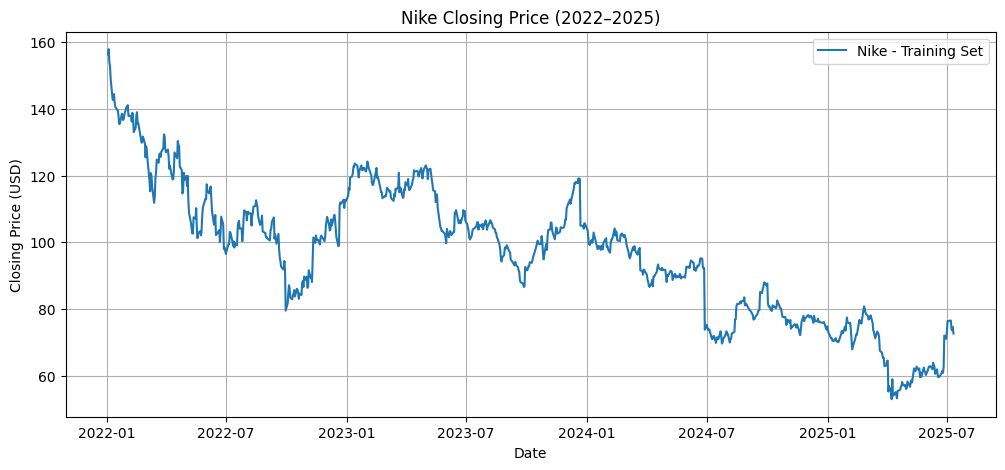

In [ ]:
# 6. Plot the full time series
plt.figure(figsize=(12, 5))
plt.plot(df_train, label='Nike - Training Set')
plt.title("Nike Closing Price (2022–2025)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

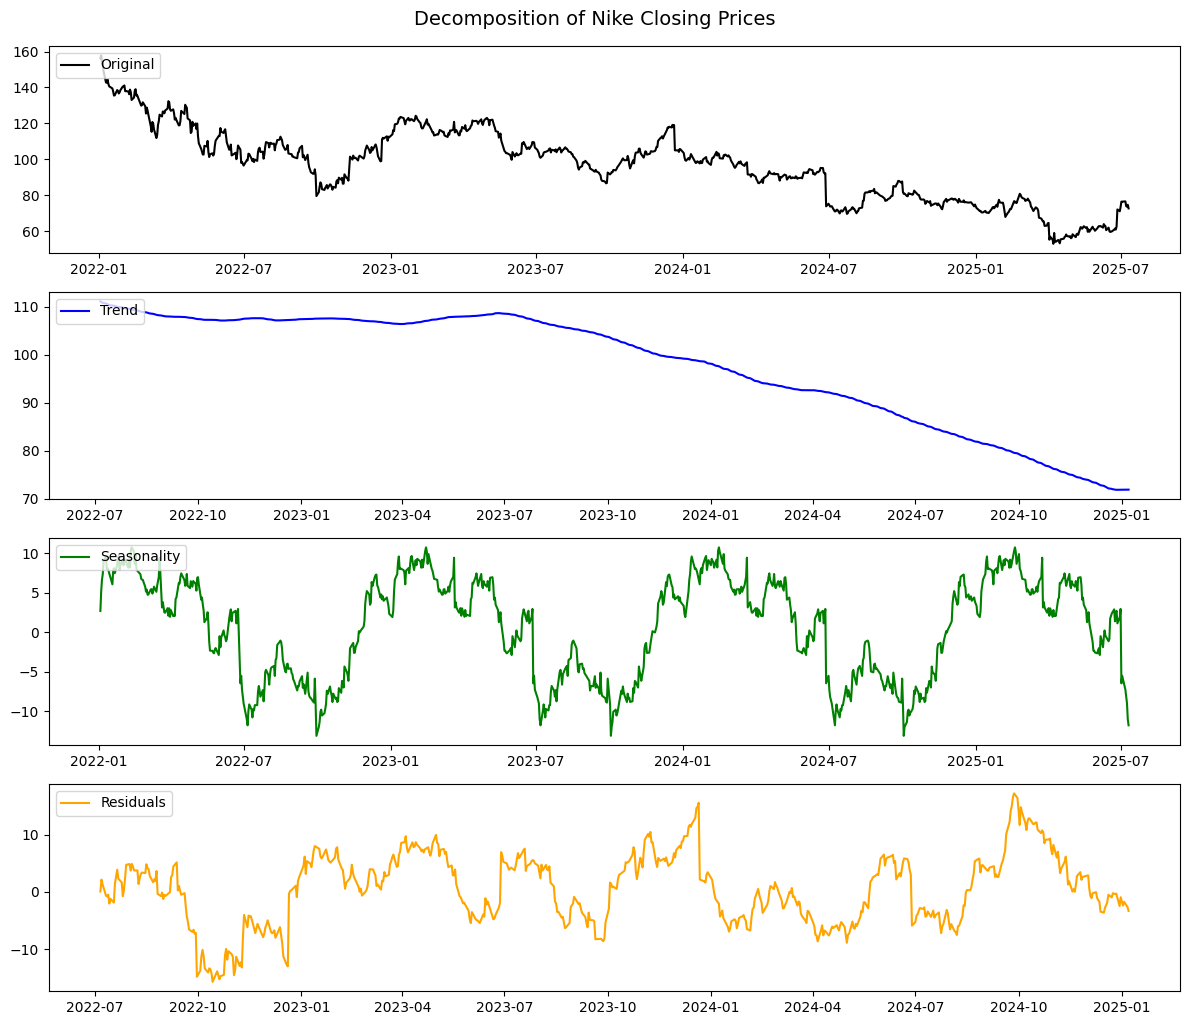

In [ ]:
# 7. Decomposition (yearly seasonality: 252 trading days)
decomposition = seasonal_decompose(df_train["Close"], model='additive', period=252)
trend = decomposition.trend
seasonality = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(df_train["Close"], label='Original', color='black')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonality, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residuals, label='Residuals', color='orange')
plt.legend(loc='upper left')

plt.tight_layout()
plt.suptitle("Decomposition of Nike Closing Prices", fontsize=14, y=1.02)
plt.show()

In [ ]:
# 8. Differencing to remove trend
diff_series = df_train["Close"].diff().dropna()

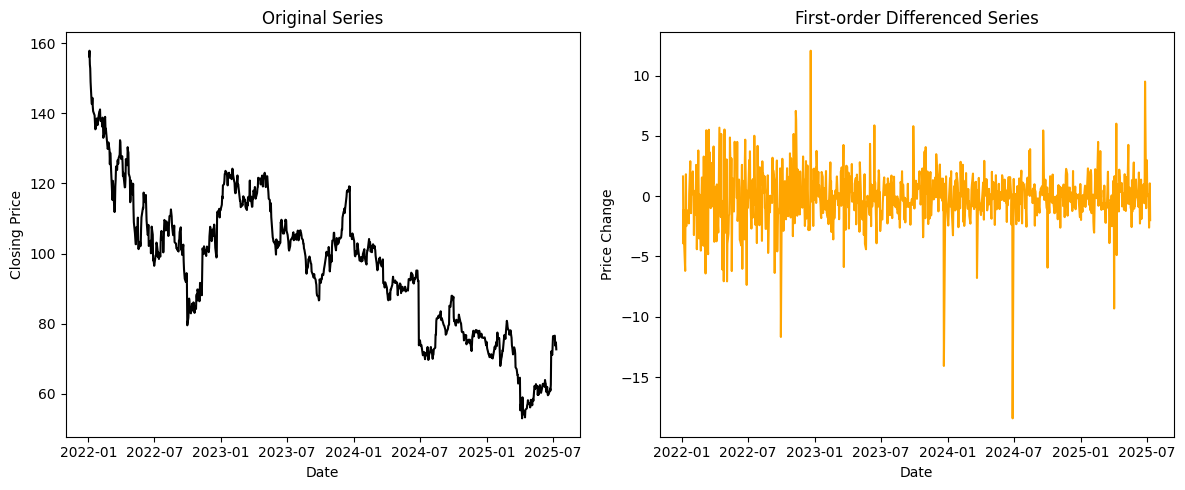

In [ ]:
# 9. Plot original vs differenced series
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df_train["Close"], color='black')
plt.title("Original Series")
plt.xlabel("Date")
plt.ylabel("Closing Price")

plt.subplot(1, 2, 2)
plt.plot(diff_series, color='orange')
plt.title("First-order Differenced Series")
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.tight_layout()
plt.show()

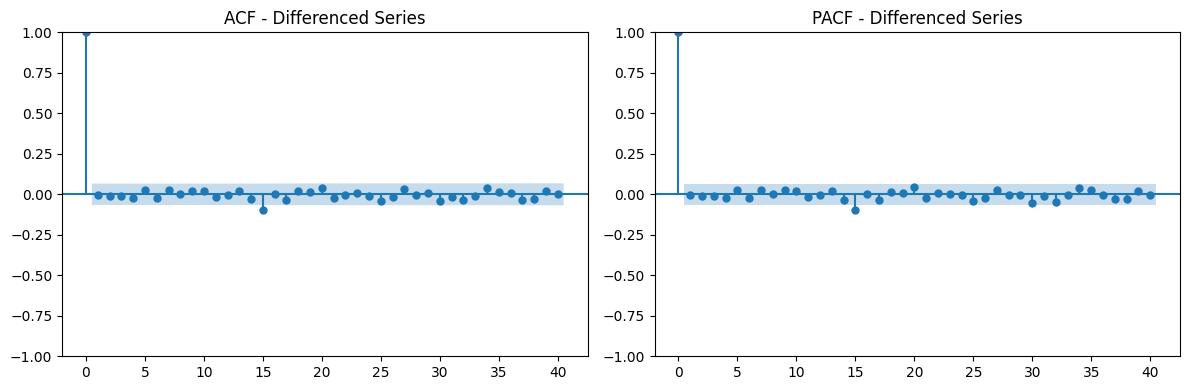

In [ ]:
# 10. ACF and PACF
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=40, ax=plt.gca())
plt.title("ACF - Differenced Series")

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=40, ax=plt.gca(), method='ywm')
plt.title("PACF - Differenced Series")
plt.tight_layout()
plt.show()

In [ ]:
# 11. ARIMA Modeling
model = ARIMA(df_train["Close"], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# 12. Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    NKE   No. Observations:                  883
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1940.697
Date:                Tue, 29 Jul 2025   AIC                           3887.394
Time:                        22:56:20   BIC                           3901.741
Sample:                             0   HQIC                          3892.880
                                - 883                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8235      1.737      0.474      0.635      -2.581       4.228
ma.L1         -0.8269      1.721     -0.481      0.631      -4.199       2.545
sigma2         4.7721      0.092     51.896      0.0

In [ ]:
# 13. Forecast next 10 values
forecast_series = model_fit.forecast(steps=10)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# 14. Compare forecast vs actual - FIX APPLIED HERE
# Ensure both Series are 1-dimensional and have matching indices
actual = df_test["Close"].values.ravel()
forecast = forecast_series.values.ravel()

comparison = pd.DataFrame({
    "Actual": actual,
    "Forecast": forecast
}, index=df_test.index)

print("\nForecast vs Actual:")
print(comparison)


Forecast vs Actual:
               Actual   Forecast
Date                            
2025-07-14  72.250000  72.628198
2025-07-15  71.989998  72.626716
2025-07-16  72.099998  72.625496
2025-07-17  72.980003  72.624491
2025-07-18  72.470001  72.623663
2025-07-21  74.019997  72.622982
2025-07-22  75.389999  72.622421
2025-07-23  76.750000  72.621959
2025-07-24  75.419998  72.621578
2025-07-25  76.269997  72.621265


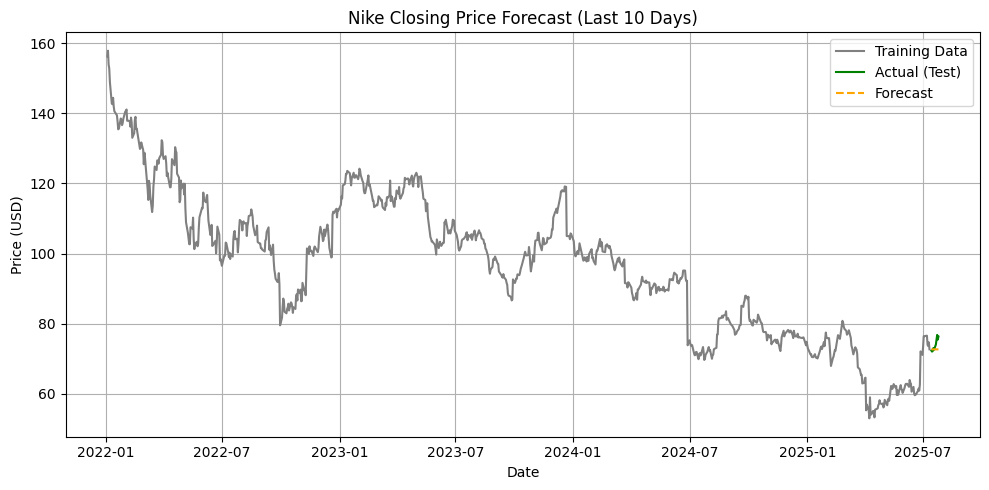

In [ ]:
# 15. Plot forecast
plt.figure(figsize=(10, 5))
plt.plot(df_train["Close"], label="Training Data", color="gray")
plt.plot(df_test["Close"], label="Actual (Test)", color="green")
plt.plot(comparison["Forecast"], label="Forecast", color="orange", linestyle="--")
plt.title("Nike Closing Price Forecast (Last 10 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

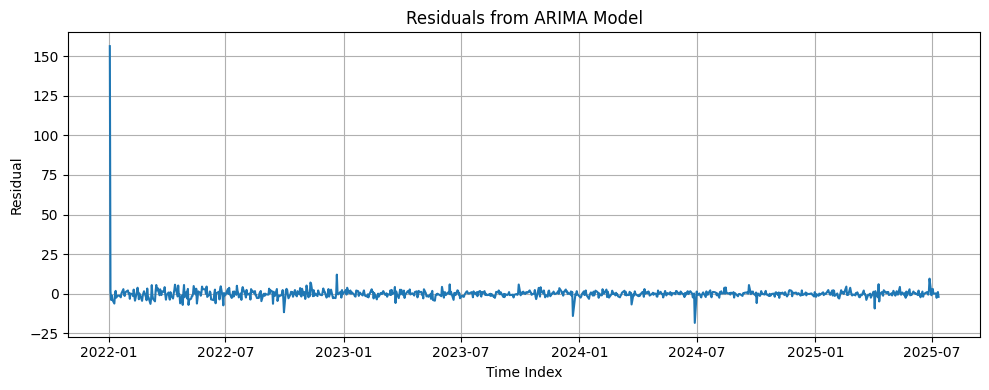

In [ ]:
# 16. Residual analysis
residuals = model_fit.resid

plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


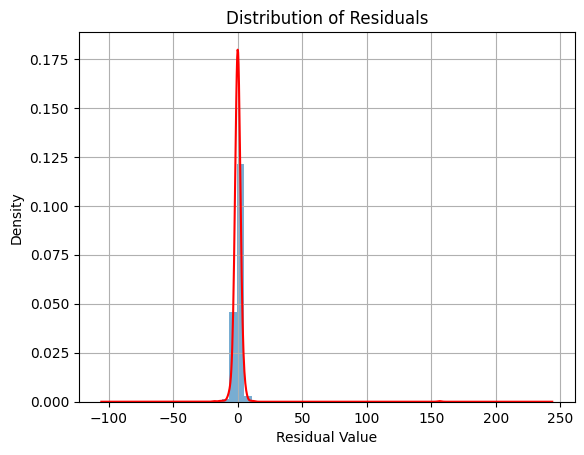

In [ ]:
# 17. Residual distribution
residuals.plot(kind='hist', bins=30, density=True, alpha=0.6)
residuals.plot(kind='kde', color='red')
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.grid(True)
plt.show()


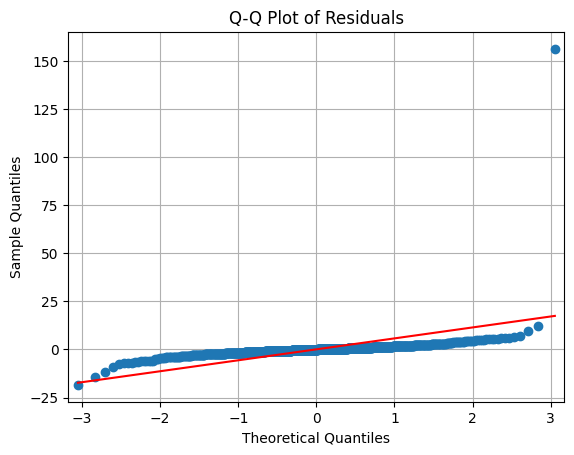

In [ ]:
# 18. Q-Q plot of residuals
qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

In [ ]:
# Error metrics for a more complete analysis
mae = mean_absolute_error(df_test["Close"], comparison["Forecast"])
rmse = np.sqrt(mean_squared_error(df_test["Close"], comparison["Forecast"]))
print(f"\nMAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 1.6789
RMSE: 2.2084
